In this notebook, I use [TinySOL](https://zenodo.org/records/3685331) dataset to test the accuracy of instrument classification using different methods.  
The accuracy of each methods are: SVM--0.67,  Neural Network--0.75, Sklearn with original featres--0.86, and Sklearn with linear projected features--0.92

## Install libraries

In [ ]:
# Install essentia
!pip install essentia

# Install libraries
!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install umap-learn

# Install datasets
!pip install mirdata

In [2]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd

## Download and process dataset

In [ ]:
# Download TinySOL dataset
TinySOL = mirdata.initialize('tinysol')
TinySOL.download()      # download the dataset
TinySOL.validate()        # validate that all the expected files are there

# Load TinySOL IDs and data
TinySOL_ids = TinySOL.track_ids             # Load TinySOL IDs
TinySOL_data = TinySOL.load_tracks()     # Load TinySOL data

# Visualize a single track
TinySOL_data[TinySOL_ids[0]]

In [4]:
# Get complete list of different instruments
instrument_names = []
for i in TinySOL_ids:
    instrument_names.append(TinySOL_data[i].instrument_full)
instrument_names = np.unique(instrument_names)

print(instrument_names)

['Accordion' 'Alto Saxophone' 'Bass Tuba' 'Bassoon' 'Cello'
 'Clarinet in Bb' 'Contrabass' 'Flute' 'French Horn' 'Oboe' 'Trombone'
 'Trumpet in C' 'Viola' 'Violin']


In [ ]:
# Create a dictionary using instument name as keys
instrument_dict = {item: [] for item in instrument_names}
for i in TinySOL_ids:
    instrument_dict[TinySOL_data[i].instrument_full].append(TinySOL_data[i].audio_path)

instrument_dict['Accordion']

## Preprocessing data

Plot waveforms of random samples of each stroke type...


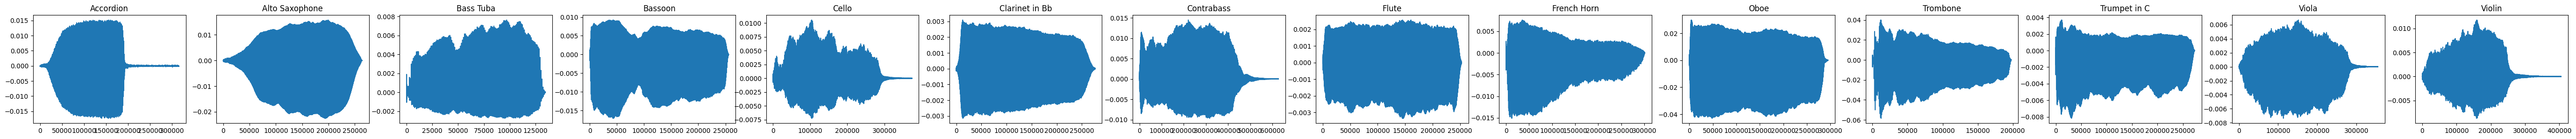

In [6]:
# Raw-data preprocess analysis parameters
_, fs = TinySOL_data[TinySOL_ids[0]].audio

num_instruments = len(instrument_dict.keys())
print("Plot waveforms of random samples of each stroke type...")
plt.figure(1, figsize=(5 * num_instruments, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, instrument in enumerate(instrument_dict.keys()):
    sample_file = instrument_dict[instrument][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()

    plt.subplot(1,num_instruments,(i+1))
    plt.plot(x)
    plt.title(instrument)

In [7]:
# Set preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005     #threshold expressed as ratio with respect to the maximum value

#Put the parameters in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [8]:
# Define function that split files
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];

    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)

    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1

    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)

    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize

    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize

    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Sample plots for waveform versus energy and splits based on energy threshold


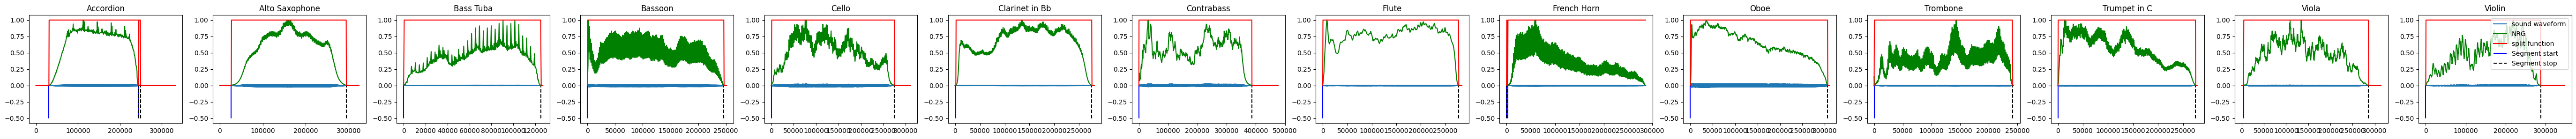

In [9]:
# Plot waveforms of energy and splits
num_instruments = len(instrument_names)
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_instruments, 3))
    for i, instrument in enumerate(instrument_dict.keys()):
        sample_file = instrument_dict[instrument][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_instruments,(i+1))
        plt.title(instrument)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");

In [10]:
# Create segments of samples
main_data_dir = 'sample_data'
if not os.path.exists(main_data_dir): #creating the directory
    os.mkdir(main_data_dir)
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir): #creating the directory
    os.mkdir(segments_dir)

segment_files = []
for instrument, files in instrument_dict.items():
    for sample_file in files:
        #Get file id
        instrument_id =  sample_file.split('__')[-1].split('.')[0]
        x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Croping segments
        for start, stop in zip(start_indexes, stop_indexes):
            x_seg = x[start: stop]
            #Final check for amplitude (to avoid silent segments selection due to noise in split function)
            if(np.max(np.abs(x_seg)) > 0.05):
                #Amplitude normalisation
                x_seg = x_seg / np.max(np.abs(x_seg))
                filename = os.path.join(segments_dir, instrument_id + '.wav')
                ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                segment_files.append(filename)

print(len(segment_files),'segment files created')

1236 segment files created


## Extract Features

In [11]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(TinySOL_data['BTb-ord-F#1-pp-N-N'].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

In [12]:
# Extract features and write in data.csv file in the segments folder
# Each line in the data.csv file represents a sample with features and the class information as the last element
data_file = 'sample_data/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['instrument']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for filename in segment_files:
        file_count +=1
        # if file_count % 20 == 0: #print name of a file every 20 files
        #     print(file_count, "files processed, current file: ", filename)

        #Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        label = filename.split('/')[-1].split('.')[0].split('-')[0]
        line2write = str(selected_features)[1:-1] + ',' + label + '\n'
        writer.write(line2write)
print("A total of ", file_count, "files processed")

A total of  1236 files processed


In [13]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.987162,5.768653,0.751439,0.222370,0.015240,1.022383,0.468274,0.315942,0.187922,6.592497,...,86.688141,3.175827,0.885207,1329860.750,1.547762e+06,0.837537,0.873005,0.027269,0.003182,Acc
1,0.986431,6.092895,0.988074,0.230592,0.016360,0.820219,0.687535,0.284934,0.170547,6.629468,...,98.092232,3.533286,1.117934,1214846.125,8.202689e+05,1.720408,0.893636,0.030611,0.004251,Acc
2,0.986427,5.979811,0.784602,0.240627,0.021323,1.034073,0.524802,0.147213,0.177022,5.765364,...,85.784760,3.899466,1.136496,1237942.750,9.111228e+05,1.854427,0.521701,0.028853,0.003775,Acc
3,0.987681,6.946106,0.594579,0.255781,0.021561,3.649251,1.378706,0.769973,0.348289,4.624568,...,54.572590,2.837744,0.954526,1681676.125,1.790846e+06,1.752451,0.484447,0.020366,0.002607,Acc
4,0.980762,7.485820,1.374415,0.190512,0.016359,2.251006,1.956147,1.287652,0.273527,9.728696,...,134.122559,1.928626,0.533582,2207014.500,2.518111e+05,1.256970,0.314124,0.022375,0.003131,Acc


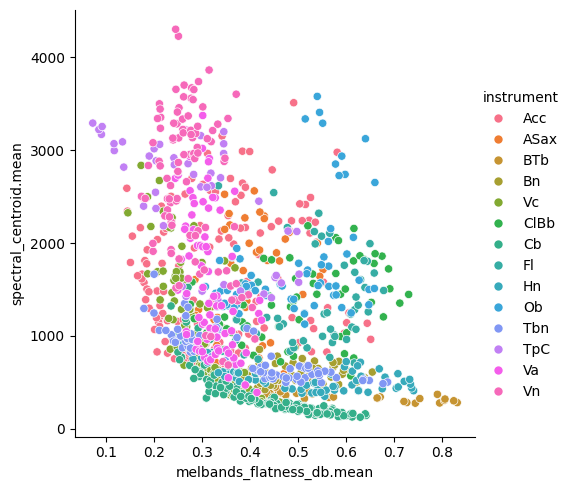

In [14]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "instrument", data = data);

## Preprocessing features

In [15]:
data_modif = data.copy()

# Use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [16]:
# Check if data is balanced (if not, we should balance it to prevent the model to be baised)
data_modif.instrument.value_counts()

,count
instrument,
Acc,181
Cb,162
Vc,145
Vn,101
Tbn,84
Va,82
Bn,77
Ob,70
Hn,68


In [17]:
# Balance data. Pick the lowest number, 45 for TpC.
min_number = data_modif.instrument.value_counts()['TpC']
Acc_data = data_modif[data_modif.instrument == 'Acc'].sample(n = min_number, random_state = 42)
Cb_data = data_modif[data_modif.instrument == 'Cb'].sample(n = min_number)
Vc_data = data_modif[data_modif.instrument == 'Vc'].sample(n = min_number)
Vn_data = data_modif[data_modif.instrument == 'Vn'].sample(n = min_number)
Tbn_data = data_modif[data_modif.instrument == 'Tbn'].sample(n = min_number)
Va_data = data_modif[data_modif.instrument == 'Va'].sample(n = min_number)
Bn_data = data_modif[data_modif.instrument == 'Bn'].sample(n = min_number)
Ob_data = data_modif[data_modif.instrument == 'Ob'].sample(n = min_number)
Hn_data = data_modif[data_modif.instrument == 'Hn'].sample(n = min_number)
ClBb_data = data_modif[data_modif.instrument == 'ClBb'].sample(n = min_number)
ASax_data = data_modif[data_modif.instrument == 'ASax'].sample(n = min_number)
Fl_data = data_modif[data_modif.instrument == 'Fl'].sample(n = min_number)
BTb_data = data_modif[data_modif.instrument == 'BTb'].sample(n = min_number)
TpC_data = data_modif[data_modif.instrument == 'TpC'].sample(n = min_number)

#Merging after downsampling
data_modif = pd.concat([Acc_data, Cb_data, Vc_data, Vn_data, Tbn_data, Va_data, Bn_data, Ob_data, Hn_data, ClBb_data, ASax_data, Fl_data, BTb_data, TpC_data])

#Check the balance again
data_modif.instrument.value_counts()

,count
instrument,
Acc,45
Cb,45
Vc,45
Vn,45
Tbn,45
Va,45
Bn,45
Ob,45
Hn,45


## Use SVM to classify instruments.

In [18]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values
# Creating output values
data_modif.instrument = pd.Categorical(data_modif.instrument)  # convert to categorical data
y = np.array(data_modif.instrument.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [9.27459413e-01 4.66493931e-01 1.29507366e-01 1.92824594e-01
 4.43947758e-02 4.07180274e-03 7.35546330e-04 1.17088105e-01
 1.66843969e-02 2.68785282e-01 1.30890971e-01 7.50051886e-01
 1.12827299e-01 2.23571205e-01 2.12245768e-01 9.04765186e-02
 3.41529458e-01 1.04103664e-01 9.86914497e-03 6.52805356e-03
 2.73744734e-01 1.78533367e-02 4.22562777e-01 1.63958543e-01
 1.49977066e-01 9.06923320e-02 5.51062314e-01 7.18107068e-02
 5.48234941e-01 2.13686961e-01 6.67973784e-01 1.08830505e-01
 4.79492903e-01 1.95982548e-01 2.78384835e-01 3.41977159e-02
 1.91917973e-02 1.25679990e-02 2.49267244e-01 5.21668877e-02
 1.43976334e-01 5.08880479e-02 6.21344148e-01 1.30977954e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 5.05828334e-02 3.23876534e-01 1.60734358e-01 1.00776213e-01
 4.12072117e-01 2.21334810e-01 9.52214542e-01 2.85269476e-02
 4.81384190e-02 2.73311020e-02 5.79868423e-03 2.88899781e-03
 6.55275195e-04 4.10604558e-04 7.37136569e-02 8.836488

In [19]:
# Split data into test sets and train sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (422, 84) , Size of train output vector:  (422,)
Size of test features matrix:  (208, 84) , Size of test output vector:  (208,)


In [20]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [21]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([False, False,  True, False,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True, False, False,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True, False,  True, False,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
       False, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False, False, False, False, False, False,
        True,  True, False,  True,  True, False, False,  True,  True,
       False, False,  True,  True,  True,  True,  True, False, False,
       False,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,

In [22]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.6682692307692307


<Axes: xlabel='Predicted', ylabel='Actual'>

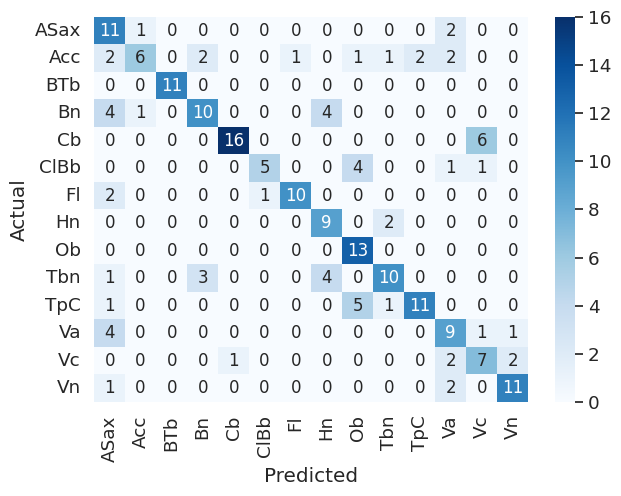

In [23]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.instrument)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True)

## Use Neural Network

In [24]:
from sklearn.preprocessing import StandardScaler

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# Normalise data
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [25]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (504, 14)
One-hot encoded y_test shape =  (126, 14)


In [ ]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):

    model = Sequential()

    # Input layer
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))

    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 14))    #There are 14 instruments in total, so the nodes of output layer should be 14
    model.add(layers.Activation('sigmoid'))

    return model

model = compose_model(X_train_val.shape[1])

In [27]:
model.summary()  # Plot summary of the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ InputLayer (BatchNormalization)      │ (None, 84)                  │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HiddenLayer_1 (Dense)                │ (None, 40)                  │           3,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40)                  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HiddenLayer_2 (Dense)                │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_layer (Dense)                 │ (None, 14)                  │             294 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 14)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,090 (19.88 KB)

 Trainable params: 4,802 (18.76 KB)

 Non-trainable params: 288 (1.12 KB)

In [28]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0)

In [29]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0907917395234108
Test accuracy: 0.7460317611694336


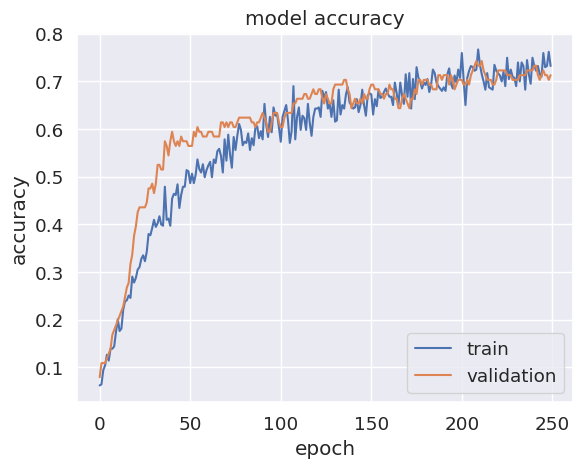

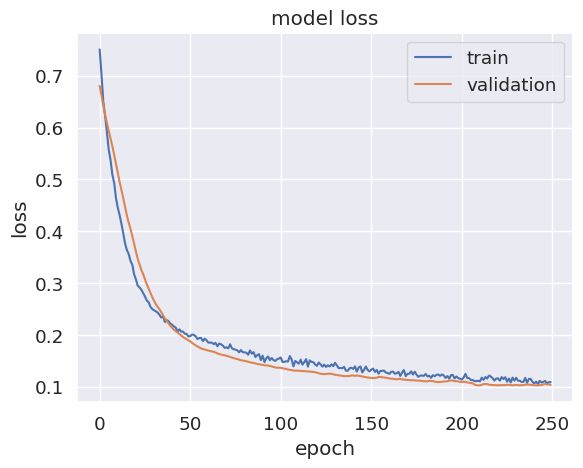

In [30]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Use sklearn

In [31]:
# We'll use some preprocessing from scikit-learn:
#  Standard scaling (z-scoring) and label encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Our classifier will be 1-nearest-neighbor after learning the distance metric
from sklearn.neighbors import KNeighborsClassifier

# Pipelines make it a little easier to manage sequences of models,
# eg scaler -> metric learner -> 1nn
from sklearn.pipeline import make_pipeline

# We'll use some standard machinery for reporting accuracy of our models
from sklearn.metrics import classification_report,  ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


RNG_STATE = 0

In [32]:
# Split test set and train set
X_train, X_test, y_train_text, y_test_text = train_test_split(data[data.columns[:-1]],data[data.columns[-1]], test_size=0.2, random_state=RNG_STATE)

In [33]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(y_train_text)

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(y_test_text)

              precision    recall  f1-score   support

        ASax       0.64      0.64      0.64        11
         Acc       0.89      0.83      0.86        30
         BTb       1.00      1.00      1.00         8
          Bn       0.93      0.87      0.90        15
          Cb       0.97      0.97      0.97        33
        ClBb       0.83      0.83      0.83        12
          Fl       0.92      0.73      0.81        15
          Hn       0.88      0.70      0.78        10
          Ob       0.80      0.92      0.86        13
         Tbn       0.76      1.00      0.86        16
         TpC       0.94      1.00      0.97        17
          Va       0.62      0.67      0.65        15
          Vc       0.86      0.86      0.86        37
          Vn       0.87      0.81      0.84        16

    accuracy                           0.86       248
   macro avg       0.85      0.85      0.85       248
weighted avg       0.86      0.86      0.86       248



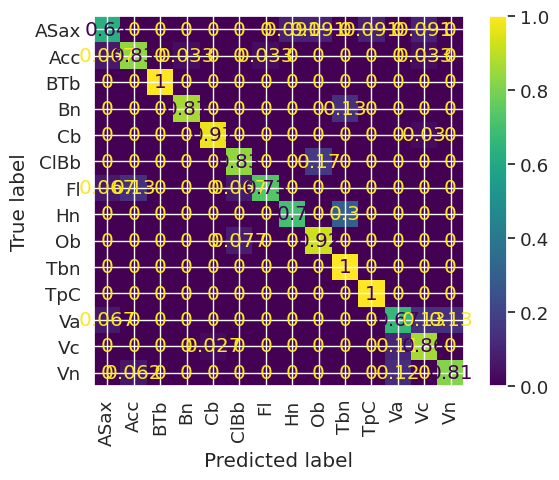

In [34]:
# Our classifier is a "pipeline": scaling followed by KNN
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

# Fit all stages of the pipeline to our training data
clf.fit(X_train, y=y_train)

# How well does our 1-Nearest neighbor model work?
y_pred = clf.predict(X_test)

# Compare our predictions to the true labels in y_test
report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

# Finally, plot a confusion matrix showing how mistakes are distributed
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

### Visualize features

In [35]:
# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

In [36]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


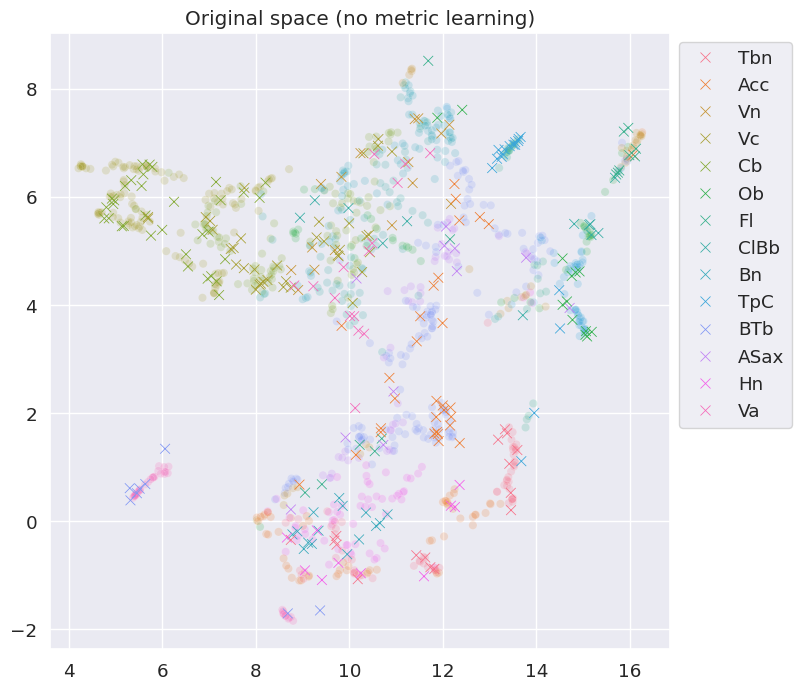

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

## Use sklearn with linear projection of features

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing lineardiscriminantanalysis, total=   0.0s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
              precision    recall  f1-score   support

        ASax       0.82      0.82      0.82        11
         Acc       0.97      0.93      0.95        30
         BTb       1.00      1.00      1.00         8
          Bn       0.88      0.93      0.90        15
          Cb       1.00      1.00      1.00        33
        ClBb       0.85      0.92      0.88        12
          Fl       1.00      0.87      0.93        15
          Hn       0.90      0.90      0.90        10
          Ob       0.85      0.85      0.85        13
         Tbn       0.83      0.94      0.88        16
         TpC       1.00      1.00      1.00        17
          Va       0.72      0.87      0.79        15
          Vc       1.00      0.97      0.99        37
          Vn       0

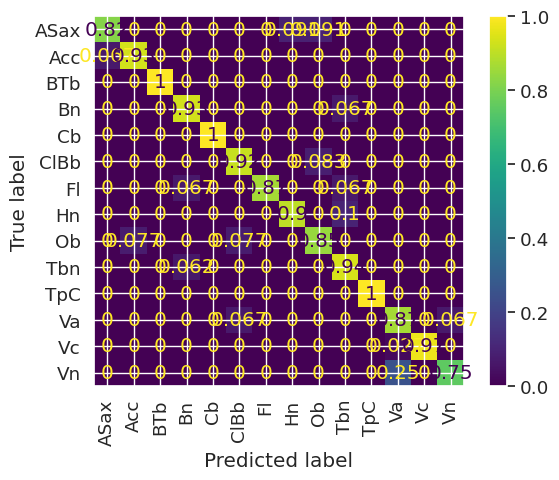

In [38]:
# Apply linear projection
clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

### Visualize features

In [39]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


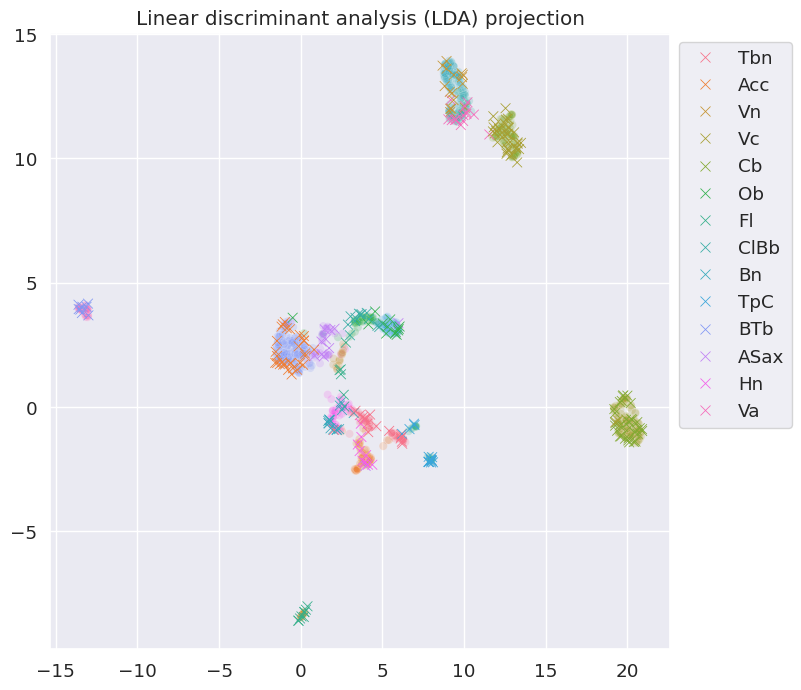

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

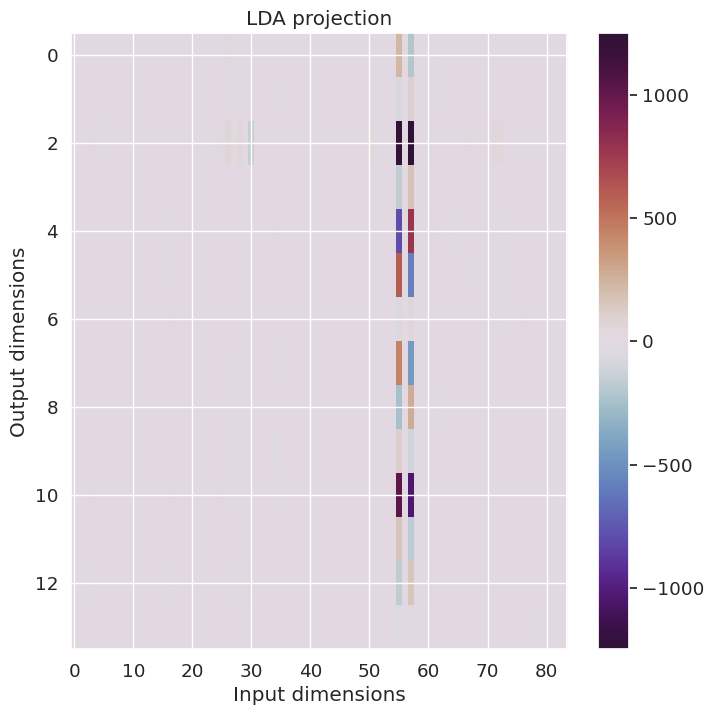

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(True)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');